# Fine-tune GIT on a custom dataset for image captioning

In this notebook, we'll fine-tune [GIT](https://huggingface.co/docs/transformers/main/en/model_doc/git), short for GenerativeImage2Text, on a toy image captioning dataset.

GIT is, at the moment of writing, a state-of-the-art image/video captioning and question answering (QA) model.

## Set-up environment

First, let's install 🤗 Transformers as well as 🤗 Datasets.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets

In [46]:
!pip install codebleu


In [47]:
!pip install tree-sitter-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 1.6 MB/s eta 0:00:00


Next, we use the [ImageFolder](https://huggingface.co/docs/datasets/main/en/image_dataset#imagefolder) feature to quickly turn this into a 🤗 Dataset. We'll specify that this is just the training split of the dataset.

In [3]:
from datasets import load_dataset

dataset = load_dataset('abhinavl/figure2code_data_square')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Let's check whether the dataset is created correctly:

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'values', 'title', 'value_heading', 'code', 'og_file_name'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['image', 'labels', 'values', 'title', 'value_heading', 'code', 'og_file_name'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['image', 'labels', 'values', 'title', 'value_heading', 'code', 'og_file_name'],
        num_rows: 1000
    })
})

In [5]:
dataset_train = dataset['train']
dataset_val = dataset['validation']
dataset_test = dataset['test']

Let's take a look at one example:

800 800


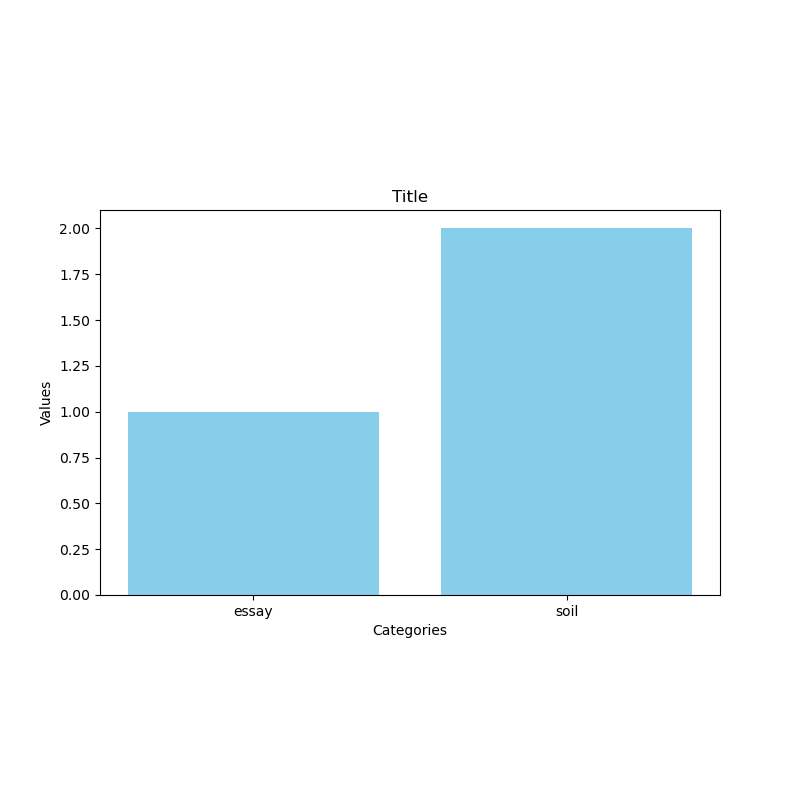

In [6]:
example = dataset_train[0]
image = example["image"]
width, height = image.size
print(width, height)
display(image.resize((int(width), int(height))))

Let's check its corresponding caption:

In [7]:
example["code"]

"\nimport matplotlib.pyplot as plt\n\n# Categories and their corresponding values\ncategories = ['essay', 'soil']\nvalues = [1, 2]\n\n# Creating the bar chart\nplt.figure(figsize=(8, 5))  # Set the figure size (optional)\nplt.bar(categories, values, color='skyblue')  # Plot the bars with skyblue color\n\n# Adding title and labels\nplt.title('Title')  # Add a title to the chart\nplt.xlabel('Categories')  # Label for the x-axis\nplt.ylabel('Values')  # Label for the y-axis\n\n# Display the chart\nplt.show()\n"

## Create PyTorch Dataset

Next, we create a standard [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Each item of the dataset returns the expected inputs for the model, in this case input_ids, attention_mask and pixel_values.

We use `GitProcessor` to turn each (image, text) pair into the expected inputs. Basically, the text gets turned into `input_ids` and `attention_mask`, and the image gets turned into `pixel_values`.

In [26]:
from torch.utils.data import Dataset
prompt = (
        "Convert the figure you are given into a full code. Here is an example of the expected output: <N>"
        "import matplotlib.pyplot as plt <N>"
        "# Categories and their corresponding values<N>"
        "categories = ['essay', 'soil']<N>"
        "values = [1, 2]<N>"
        "# Creating the bar chart<N>"
        "plt.figure(figsize=(8, 5))  # Set the figure size (optional)<N>"
        "plt.bar(categories, values, color='skyblue')  # Plot the bars with skyblue color<N>"
        "# Adding title and labels<N>"
        "plt.title('Title')  # Add a title to the chart<N>"
        "plt.xlabel('Categories')  # Label for the x-axis<N>"
        "plt.ylabel('Values')  # Label for the y-axis<N>"
        "# Display the chart<N>"
        "plt.show()"
    )

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=prompt, padding="max_length", return_tensors="pt")
        label = self.processor(text=item["code"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        label = {k: v.squeeze() for k,v in label.items()}
        return encoding, label, item["code"]

In [28]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base-vqav2")

In [29]:
test_dataset = ImageCaptioningDataset(dataset_test, processor)
train_dataset = ImageCaptioningDataset(dataset_train, processor)
val_dataset = ImageCaptioningDataset(dataset_val, processor)

Let's check one example of the dataset:

In [31]:
item, label, code = test_dataset[0]
for k,v in item.items():
  print(k,v.shape)
for k,v in label.items():
  print(k,v.shape)
print(code)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 480, 480])
input_ids torch.Size([512])
attention_mask torch.Size([512])

import matplotlib.pyplot as plt

# Categories and their corresponding values
categories = ['pain', 'stock', 'graph']
values = [7, 2, 2]

# Creating the bar chart
plt.figure(figsize=(8, 5))  # Set the figure size (optional)
plt.bar(categories, values, color='skyblue')  # Plot the bars with skyblue color

# Adding title and labels
plt.title('Accuracy of different algorithms')  # Add a title to the chart
plt.xlabel('Categories')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis

# Display the chart
plt.show()



## Create PyTorch DataLoader

Next, we create a corresponding [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allows us to get batches of data from the dataset.

We need this as neural networks (like GIT) are trained on batches of data, using stochastic gradient descent (SGD).

In [32]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=4)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=4)

In [33]:
batch, label, code = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)


input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
pixel_values torch.Size([4, 3, 480, 480])


In [34]:
print(code)

("\nimport matplotlib.pyplot as plt\n\n# Categories and their corresponding values\ncategories = ['image', 'bath', 'area', 'tissue', 'ideal', 'vein']\nvalues = [1000000000, 1000000000, 10000, 1000000000, 10, 10000000]\n\n# Creating the bar chart\nplt.figure(figsize=(8, 5))  # Set the figure size (optional)\nplt.bar(categories, values, color='skyblue')  # Plot the bars with skyblue color\n\n# Adding title and labels\nplt.title('Title')  # Add a title to the chart\nplt.xlabel('Categories')  # Label for the x-axis\nplt.ylabel('Values')  # Label for the y-axis\n\n# Display the chart\nplt.show()\n", "\nimport matplotlib.pyplot as plt\n\n# Categories and their corresponding values\ncategories = ['bomb', 'game', 'scope', 'roof', 'run']\nvalues = [3, 5, 1, 2, 8]\n\n# Creating the bar chart\nplt.figure(figsize=(8, 5))  # Set the figure size (optional)\nplt.bar(categories, values, color='skyblue')  # Plot the bars with skyblue color\n\n# Adding title and labels\nplt.title('Most preferred objects

Let's check one batch, and do some sanity checks. We can decode the input_ids back into text for instance:

In [35]:
processor.decode(batch["input_ids"][0])

"[CLS] convert the figure you are given into a full code. here is an example of the expected output : < n > import matplotlib. pyplot as plt < n > # categories and their corresponding values < n > categories = ['essay ','soil'] < n > values = [ 1, 2 ] < n > # creating the bar chart < n > plt. figure ( figsize = ( 8, 5 ) ) # set the figure size ( optional ) < n > plt. bar ( categories, values, color ='skyblue') # plot the bars with skyblue color < n > # adding title and labels < n > plt. title ('title') # add a title to the chart < n > plt. xlabel ('categories') # label for the x - axis < n > plt. ylabel ('values') # label for the y - axis < n > # display the chart < n > plt. show ( ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [36]:
processor.decode(label["input_ids"][0])

"[CLS] import matplotlib. pyplot as plt # categories and their corresponding values categories = ['image ','bath ','area ','tissue ','ideal ','vein'] values = [ 1000000000, 1000000000, 10000, 1000000000, 10, 10000000 ] # creating the bar chart plt. figure ( figsize = ( 8, 5 ) ) # set the figure size ( optional ) plt. bar ( categories, values, color ='skyblue') # plot the bars with skyblue color # adding title and labels plt. title ('title') # add a title to the chart plt. xlabel ('categories') # label for the x - axis plt. ylabel ('values') # label for the y - axis # display the chart plt. show ( ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

We can "denormalize" the pixel values to get back an image:

(480, 480, 3)


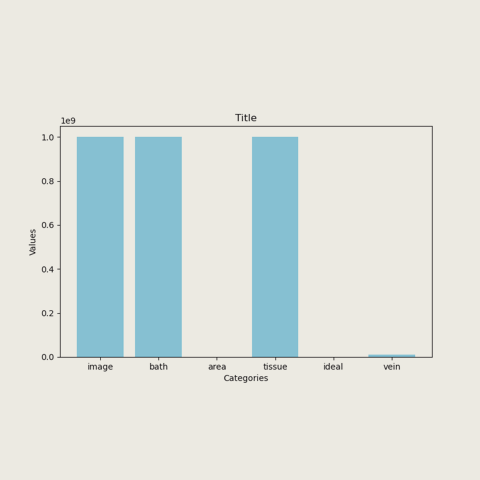

In [37]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
print(unnormalized_image.shape)
Image.fromarray(unnormalized_image)

Looks ok! Always important to check your data ;) see [this blog](http://karpathy.github.io/2019/04/25/recipe/) for a great overview of tips when training neural networks.

## Define model

Next, we instantiate a model. We start from the pre-trained GIT-base model (which was already pre-trained on 4 million image-text pairs by Microsoft).

Of course, feel free to start fine-tuning another GIT model from the [hub](https://huggingface.co/models?other=git).

In [38]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-vqav2")

## Dummy forward pass

It's always good to check the initial loss on a batch. See also the blog above.

In [39]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=label["input_ids"])
outputs.loss

tensor(11.4466, grad_fn=<NllLossBackward0>)

Code for Eval

In [58]:
from tqdm import tqdm
from codebleu import calc_codebleu

def get_codebleu_scores(targets, preds):
    total_codebleu = 0
    for index in range(len(targets)):
        codebleu_score = calc_codebleu([targets[index]], [preds[index]], lang="python", weights=(0.25, 0.25, 0.25, 0.25), tokenizer=None)
        total_codebleu += codebleu_score['codebleu']
    return total_codebleu / len(df_targets)

# Batch size
batch_size_inf = 8

# Function to process a batch of images
def process_batch(batch_images, prompt, model):
    with torch.no_grad():
      inputs = processor(images=batch_images, text=[prompt] * len(batch_images), return_tensors="pt", padding=True).to('cuda')
      pixel_values = inputs.pixel_values
      generated_ids = model.generate(input_ids=inputs.input_ids, pixel_values=pixel_values, max_length=500)
      generated_codes = processor.batch_decode(generated_ids, skip_special_tokens=True)
    return generated_codes

def eval_model(model, dataset_test, prompt):
    # List to store the generated captions
    codes = []
    for i in tqdm(range(0, len(dataset_test), batch_size_inf), desc="Evaluating Model"):
        batch_images = [dataset_test[j]['image'] for j in range(i, min(i + batch_size_inf, len(dataset_test)))]
        batch_codes = process_batch(batch_images, prompt, model)
        codes.extend(batch_codes)
    df = pd.DataFrame(codes, columns=["code"])
    codebleu_score = get_codebleu_scores(dataset_test['code'], df['code'])
    return codebleu_score, df


In [50]:
dataset_test[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=800x800>,
 'labels': "['pain', 'stock', 'graph']",
 'values': '[7, 2, 2]',
 'title': 'Accuracy of different algorithms',
 'value_heading': 'Accuracy',
 'code': "\nimport matplotlib.pyplot as plt\n\n# Categories and their corresponding values\ncategories = ['pain', 'stock', 'graph']\nvalues = [7, 2, 2]\n\n# Creating the bar chart\nplt.figure(figsize=(8, 5))  # Set the figure size (optional)\nplt.bar(categories, values, color='skyblue')  # Plot the bars with skyblue color\n\n# Adding title and labels\nplt.title('Accuracy of different algorithms')  # Add a title to the chart\nplt.xlabel('Categories')  # Label for the x-axis\nplt.ylabel('Accuracy')  # Label for the y-axis\n\n# Display the chart\nplt.show()\n",
 'og_file_name': 'figure_8199.png'}

In [57]:
model.to('cuda')
codebleu_score, df = eval_model(model, dataset_test, prompt)
print(codebleu_score)

Evaluating Model:   5%|▍         | 6/125 [01:22<27:13, 13.73s/it]


KeyboardInterrupt: 

## Train the model

Next, let's train the model! We use native PyTorch here.

As I created a super tiny dataset just for demo purposes, we'll let the model overfit it. If it's capable of overfitting it (i.e. achieve zero loss), then that's a great way to know that everything is working properly. See also the blog above.

In [69]:
# Training loop
for epoch in range(10):
    print("Epoch:", epoch)
    train_codebleu = 0
    total_loss = 0
    num_batches = 0

    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}")
    for idx, (batch, labels, code) in enumerate(progress_bar):
        model.train()

        input_ids = batch.pop("input_ids").to(device)
        attention_mask = batch.pop("attention_mask").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        output_ids = labels.pop("input_ids").to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        pixel_values=pixel_values,
                        labels=output_ids)

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        num_batches += 1
        average_loss = total_loss / num_batches


        progress_bar.set_postfix({"Average Loss": average_loss})

    train_losses.append(average_loss)
    # Evaluate on validation set
    val_codebleu = evaluate_model(model, val_dataloader)
    val_codebleu_scores.append(val_codebleu)
    print(f"Validation CodeBLEU: {val_codebleu}")

    # Save the best model
    if val_codebleu > best_val_codebleu:
        best_val_codebleu = val_codebleu
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved.")

# Plotting loss and CodeBLEU scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_codebleu_scores, label="Validation CodeBLEU")
plt.xlabel("Epoch")
plt.ylabel("CodeBLEU")
plt.title("CodeBLEU Scores")
plt.legend()

plt.show()

Epoch: 0


Training Epoch 1:   1%|          | 18/2000 [00:19<36:11,  1.10s/it, Average Loss=7.06, Train CodeBLEU=0]


KeyboardInterrupt: 

## Inference

Now that we've trained the model, let's load the Maradona image and perform inference on it.

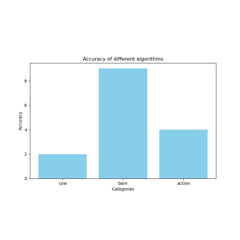

In [23]:
# load image
example = dataset_test[5]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [70]:
import pandas as pd

# Batch size
batch_size = 1
# List to store the generated captions
codes = []

# Function to process a batch of images
def process_batch(batch_images, prompt):
    inputs = processor(images=batch_images, text=[prompt] * len(batch_images), return_tensors="pt", padding=True).to('cuda')
    pixel_values = inputs.pixel_values
    generated_ids = model.generate(input_ids=inputs.input_ids, pixel_values=pixel_values, max_length=500)
    generated_codes = processor.batch_decode(generated_ids, skip_special_tokens=True)
    return generated_codes

#Load best model:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
# Process dataset in batches
for i in range(0, len(dataset_test), batch_size):
    batch_images = [dataset_test[j]['image'] for j in range(i, min(i + batch_size, len(dataset_test)))]
    batch_codes = process_batch(batch_images, prompt)
    codes.extend(batch_codes)
    print(f"Processed {i} to {i + len(batch_images)}")
# Create a DataFrame from the codes list
df = pd.DataFrame(codes, columns=["Generated_Code"])

# Display the DataFrame
print(df)

# Optionally, you can save the DataFrame to a CSV file
df.to_csv("generated_codes.csv", index=False)


KeyboardInterrupt: 

Great! We've successfully fine-tuned GIT on our tiny (image, text) dataset to generate captions of images of football players.

In [ ]:
codes[0]